# Part 1 - Getting Started and Data Preparation

In this deep learning tutorial notebook, we will cover the following topics:

* Hardware and software tools for deep learning
* Working with Keras and Tensorflow
* Loading and inspecting the CIFAR10 data

Note about shell commands in Jupyter Notebooks: To avoid having to open a separate terminal window, we will be using a Jupyter feature that allows you to execute commands in the bash shell by starting the line with a `!`.  For example:
```
! ls *.ipynb
```
will show all the Jupyter notebooks in the current directory.  These commands could just as well be typed in a terminal window.

## Tools for Deep Learning

In this tutorial, we will focus on the [Keras](https://keras.io) neural networking library.  Keras provides an easy-to-use, high level Python API for building and training neural networks, and has quickly become the most popular interface for deep learning.  Part of the power of Keras is that it delegates the computation to one of the following deep learning frameworks:
* TensorFlow
* Theano
* Microsoft Cognitive Toolkit (also known as "CNTK")

TensorFlow is the default Keras backend, and that is what we will use for this tutorial.  This will enable us to make use of TensorFlow tools, like TensorBoard, in later tutorial units.

### Hardware/OS Requirements

The benefit of libraries like Keras/TensorFlow is that they are designed to be *hardware indepenedent*.  The same code model code (with few exceptions) will execute on either the CPU or the GPU.  This allows you to train on a system with a GPU, and deploy on a server with only CPUs, or any combination.

We will be using GPUs to speed up our training today.  Any NVIDIA GPU from the last 5 years can be used with TensorFlow, although for most problems we suggest a GPU with at least 8 GB of memory.  The GeForce product line is fine for learning, but generally the Titan or Quadro cards are better for workstations and the Tesla cards for servers.  For deep learning, we generally suggest:

* GeForce 1080 or 1080 Ti
* Titan Xp or V
* Quadro P100 or V100
* Tesla K40, K80, P100, or V100

The Tesla K80, P100 and V100 can be rented from most cloud computing providers.

For the best experience, we suggest using Linux for GPU-accelerated deep learning.  We will be using Ubuntu Linux 64-bit 16.04 in this tutorial, but any Linux distribution supported by the [official NVIDIA drivers](http://www.nvidia.com/Download/index.aspx).  If you are using Anaconda, you do not need to install CUDA to use the GPU-accelerated packages, but the official NVIDIA drivers (not the free Nouveau drivers that come preinstalled with some Linux distributions) are required.

On Linux, we can check the GPU hardware available on our system with the `nvidia-smi` command:

In [1]:
! nvidia-smi

Sat Apr  7 16:53:23 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   39C    P8    17W / 250W |     10MiB / 12188MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   31C    P8    17W / 250W |     10MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

This table shows the GPU name, total and used GPU memory, temperature, power consumption, and utilization.  For this tutorial, we will be using the slightly older Tesla K80 cards with 12 GB of memory per device.

### Software Requirements

Once you have access to a suitable NVIDIA GPU and operating system drivers, you can get started very quickly by installing [Anaconda for 64-bit Linux](https://www.anaconda.com/download/?lang=en-us#linux).

Once Anaconda is installed, you can use `conda` to install the GPU-accelerated Keras/TensorFlow:
```
conda install keras-gpu
```
(For this tutorial, we also use the `notebook`, `h5py`, `bokeh`, and `holoviews` packages.)

We have already preloaded these packages into the tutorial environment, which you can verify with `conda list`:

In [2]:
! conda list 'keras|tensorflow|bokeh|holoviews|notebook|h5py'  # Using a regular expression to only show some packages

# packages in environment at /home/seibert/anaconda/envs/ac2018:
#
# Name                    Version                   Build  Channel
bokeh                     0.12.13          py36h2f9c1c0_0  
h5py                      2.7.1            py36h3585f63_0  
holoviews                 1.9.4                    py36_0  
keras-gpu                 2.1.5                    py36_0  
notebook                  5.4.0                    py36_0  
tensorflow-gpu            1.4.1                         0  
tensorflow-gpu-base       1.4.1            py36h01caf0a_0  
tensorflow-tensorboard    0.4.0            py36hf484d3e_0  


## Working With Keras and TensorFlow

Now that we have verified the correct conda packages are installed, let's start importing some libraries.  First, we are going to import Holoviews (for plotting) and enable the Bokeh backend:


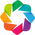

In [3]:
import numpy as np
np.warnings.filterwarnings('ignore')  # Hide np.floating warning
import holoviews as hv
import colorcet as cc
hv.extension('bokeh')

Next, let's import Keras:

In [4]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

### TensorFlow and GPU Memory

Even though we are using Keras for the majority of the tutorial, we can also import and access TensorFlow directly.

Allocating and deallocating GPU memory can be slow (much slower than on the CPU), so most deep learning frameworks use *memory pools* to speed things up.  When a TensorFlow session initializes the GPU, it grabs 90% of the GPU memory in one big block, and then internally divides it up for different arrays.  This is normally not a problem, but we will have several notebooks open at once in this tutorial, each one with its own TensorFlow session.  For that reason, we will use the following trick to tell TensorFlow it is OK to grow its allocation as needed, rather than taking all 90% up front.

In [5]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Let's verify our GPUs have been detected by TensorFlow:

In [6]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2708739797721455363, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11969331200
 locality {
   bus_id: 1
 }
 incarnation: 18308716681424069938
 physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 11970638644
 locality {
   bus_id: 1
 }
 incarnation: 10456899858565543118
 physical_device_desc: "device: 1, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"]

Here we can see that TensorFlow has detected both CPU and GPU devices.

## Loading and Inspecting the CIFAR10 Data

Keras includes a [datasets](https://keras.io/datasets/) package that will automatically download and import standard test datasets into NumPy arrays.

For this tutorial, we will use the CIFAR10 image set, which has the following properties:

* 32x32 pixel RGB images
* Each image is from 1 of 10 categories (represented numerically from 0 through 9)
* 50000 training images, 10000 test images

Let's load the data:

In [7]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# The data only has numeric categories so we also have the string labels below 
cifar10_labels = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 
                           'dog', 'frog', 'horse', 'ship', 'truck'])

The data is organized into NumPy arrays of image data and label data, which we can see from the shape information:

In [8]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


For the `x` arrays, the indices are ordered:

* image number
* image row
* image column
* color channel (0=R, 1=G, 2=B)

We can pull out a single image and plot it:

In [9]:
%%output size=48
%%opts RGB [xaxis=None yaxis=None]
# For more information on Holoviews configuration, see http://holoviews.org/user_guide/Customizing_Plots.html

i = 12
print(cifar10_labels[y_train[i][0]])
hv.RGB(x_train[i])

horse


:RGB   [x,y]   (R,G,B)

In [10]:
%%output size=48
%%opts Image [xaxis=None yaxis=None] (cmap='gray')

i = 12
print(cifar10_labels[y_train[i][0]])
hv.Image(x_train[i,:,:,0], label='r') \
  + hv.Image(x_train[i,:,:,1], label='g') \
  + hv.Image(x_train[i,:,:,2], label='b')

horse


:Layout
   .Image.R :Image   [x,y]   (z)
   .Image.G :Image   [x,y]   (z)
   .Image.B :Image   [x,y]   (z)

If we want to see a bunch of images from a particular class, we can use NumPy fancy indexing and Holoviews layouts to make a grid:

In [11]:
%%output size=32
%%opts RGB [xaxis=None yaxis=None]

# Deer are class 4
deer = (y_test[:,0] == 4)


images = [hv.RGB(x_test[deer][i]) for i in range(24)]
hv.Layout(images).cols(8)

:Layout
   .RGB.I     :RGB   [x,y]   (R,G,B)
   .RGB.II    :RGB   [x,y]   (R,G,B)
   .RGB.III   :RGB   [x,y]   (R,G,B)
   .RGB.IV    :RGB   [x,y]   (R,G,B)
   .RGB.V     :RGB   [x,y]   (R,G,B)
   .RGB.VI    :RGB   [x,y]   (R,G,B)
   .RGB.VII   :RGB   [x,y]   (R,G,B)
   .RGB.VIII  :RGB   [x,y]   (R,G,B)
   .RGB.IX    :RGB   [x,y]   (R,G,B)
   .RGB.X     :RGB   [x,y]   (R,G,B)
   .RGB.XI    :RGB   [x,y]   (R,G,B)
   .RGB.XII   :RGB   [x,y]   (R,G,B)
   .RGB.XIII  :RGB   [x,y]   (R,G,B)
   .RGB.XIV   :RGB   [x,y]   (R,G,B)
   .RGB.XV    :RGB   [x,y]   (R,G,B)
   .RGB.XVI   :RGB   [x,y]   (R,G,B)
   .RGB.XVII  :RGB   [x,y]   (R,G,B)
   .RGB.XVIII :RGB   [x,y]   (R,G,B)
   .RGB.XIX   :RGB   [x,y]   (R,G,B)
   .RGB.XX    :RGB   [x,y]   (R,G,B)
   .RGB.XXI   :RGB   [x,y]   (R,G,B)
   .RGB.XXII  :RGB   [x,y]   (R,G,B)
   .RGB.XXIII :RGB   [x,y]   (R,G,B)
   .RGB.XXIV  :RGB   [x,y]   (R,G,B)

Note that Holoviews/Bokeh/Matplotlib all assume images are in RGB format, but not all systems load images that way.  For example, [OpenCV](https://opencv.org/) loads images from files and webcams in BGR format.  To get a sense what that error looks like, we can simulate what that would look like by reversing the 4th axis:

In [12]:
%%output size=48
%%opts RGB [xaxis=None yaxis=None]
# For more information on Holoviews configuration, see http://holoviews.org/user_guide/Customizing_Plots.html

i = 12
print(cifar10_labels[y_train[i][0]])
hv.RGB(x_train[i], label='Correct (RGB)') + hv.RGB(x_train[i,:,:,::-1], label='Flipped (BGR)')

horse


:Layout
   .RGB.Correct_left_parenthesis_RGB_right_parenthesis :RGB   [x,y]   (R,G,B)
   .RGB.Flipped_left_parenthesis_BGR_right_parenthesis :RGB   [x,y]   (R,G,B)

### Rescaling Data for Neural Networks

For reasons of numerical precision and stability, it is a good idea to scale inputs to the network so that they are floating point numbers approximately between -1 and 1.  For best training performance on the GPU, using 32-bit floating point numbers is preferred since those have higher performance (between 2x and 24x depending on your GPU) than 64-bit floating point numbers.

We can use standard NumPy functions and expressions to make this conversion:

In [13]:
x_train_norm = x_train.astype('float32')
x_test_norm = x_test.astype('float32')
x_train_norm /= 255
x_test_norm /= 255
print('x_train dtype:', x_train_norm .dtype)
print('x_train min/max:', x_train_norm .min(), x_train_norm .max())

x_train dtype: float32
x_train min/max: 0.0 1.0


For the output labels of the network, we will use one-hot encoding.  To use one-hot encoding, we need to know the number of categories (or "classes") in our data.  For CIFAR10, that number is 10.

In [14]:
import keras.utils

num_classes = 10

y_train_norm = keras.utils.to_categorical(y_train, num_classes)
y_test_norm = keras.utils.to_categorical(y_test, num_classes)

We can look at the first 5 rows to see how there is a single `1` in each column:

In [15]:
print('y_train shape:', y_train_norm.shape)
y_train_norm[:5]

y_train shape: (50000, 10)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

Note that if we ever want to convert one-hot encoding back to category numbers, we can use the NumPy `argmax` function to find the column number with the largest value along axis 1 for each row:

In [16]:
np.argmax(y_train_norm, axis=1)[:5]

array([6, 9, 9, 4, 1])

Because these transformations of the input and category labels are quick, we will not load pre-transformed data from disk in future units.  However, if we wanted to save the transformed arrays, we could save them in an HDF5 file:

In [17]:
import h5py

with h5py.File('transformed_data.hdf5', 'w') as f:
    f.create_dataset('x_train', data=x_train_norm)
    f.create_dataset('y_train', data=y_train_norm)
    f.create_dataset('x_test', data=x_test_norm)
    f.create_dataset('y_test', data=y_test_norm)

These files can get very big:

In [18]:
! ls -lh transformed_data.hdf5

-rw-rw-r-- 1 seibert seibert 708M Apr  7 16:53 transformed_data.hdf5


To load the data later:

In [19]:
with h5py.File('transformed_data.hdf5', 'r') as f:
    x_train_norm = f['x_train'][:] # The extra slice [:] forces h5py to load into memory
    y_train_norm = f['y_train'][:] # The extra slice [:] forces h5py to load into memory
    x_test_norm = f['x_test'][:] # The extra slice [:] forces h5py to load into memory
    y_test_norm = f['y_test'][:] # The extra slice [:] forces h5py to load into memory

In [20]:
print(x_train_norm.shape)
print(x_train_norm.dtype)

(50000, 32, 32, 3)
float32
